In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [ ]:
def load_data(filename):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string.
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    return np.loadtxt(filename, skiprows=1, delimiter=',')

data = load_data('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv')
data2 = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv')
movies = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv')
test = load_data('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/test.csv')
train = load_data('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/train.csv')

movie_list = movies["Movie Title"].tolist()
# movies.drop("Movie Title", axis=1, inplace=True)

## HW5 Modified Implementation

In [ ]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - (Vj * (Yij - np.dot(Ui, Vj))))

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - (Ui * (Yij - np.dot(Ui, Vj))))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    sum = 0
    for y in Y:
        (i, j, Y_ij) = y 
        sum += (Y_ij - np.dot(U[i-1], V[j-1]))**2
    if reg == 0:
        return (.5 * sum) / len(Y)
    print('no')
    return ((reg / 2) * ((np.linalg.norm(U, ord='fro') ** 2) + (np.linalg.norm(V, ord='fro') ** 2))
            + .5 * sum) / len(Y)


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U, V = np.random.uniform(-.5, .5, size=(M, K)), np.random.uniform(-.5, .5, size=(N, K))
    init_err = get_err(U, V, Y)
    prev_err = init_err
    for epoch in range(max_epochs):
        idxs = np.random.permutation(len(Y))
        for idx in idxs:
            i, j, Y_ij = Y[idx][0] - 1, Y[idx][1] - 1, Y[idx][2]
            U[i] -= grad_U(U[i], Y_ij, V[j], reg, eta)
            V[j] -= grad_V(V[j], Y_ij, U[i], reg, eta)
        curr_err = get_err(U, V, Y)
        if epoch == 0:
            init_err -= curr_err
            prev_err = curr_err
        else:
            if (prev_err - curr_err) / init_err <= eps:
                break
        prev_err = curr_err 
    return (U, V, get_err(U, V, Y))

## Tuning Parameters

In [ ]:
Y_train = train.astype('int32')
Y_test = test.astype('int32')

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20
# epochs = [100, 200]

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []


Factorizing with  943  users,  1682  movies.


0
0.001
0.01
0.1
1
10


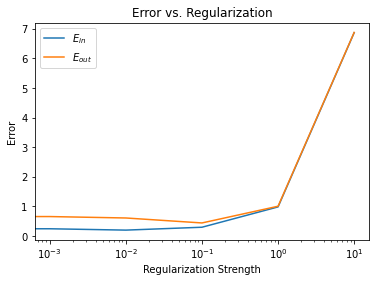

In [ ]:
# find good regularization
E_in, E_out = [], []
eta = .03
lambdas = [0, 1e-3, 1e-2, 1e-1, 1, 10]
# default 300 epochs
for reg in lambdas:
    print(reg)
    U, V, err = train_model(M, N, K, eta, reg, Y_train)
    E_in.append(err)
    E_out.append(get_err(U, V, Y_test))
plt.xscale("log")
plt.plot(lambdas, E_in, label='$E_{in}$')
plt.plot(lambdas, E_out, label='$E_{out}$')
plt.title('Error vs. Regularization')
plt.xlabel('Regularization Strength')
plt.ylabel('Error')
plt.legend()

1e-06
1e-05
0.0001
0.001
0.01
0.1


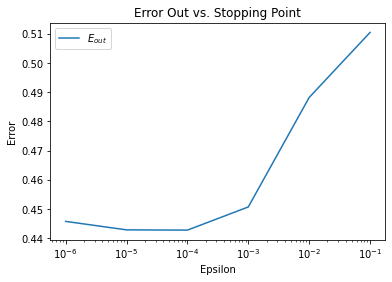

In [ ]:
# find good stopping cutoff
reg = 0.1
epsilons = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
# default 300 epochs
E_in, E_out = [], []
for eps in epsilons:
    print(eps)
    U, V, err = train_model(M, N, K, eta, reg, Y_train, eps=eps)
    E_in.append(err)
    E_out.append(get_err(U, V, Y_test))
plt.xscale("log")
# plt.plot(epsilons, E_in, label='$E_{in}$')
plt.plot(epsilons, E_out, label='$E_{out}$')
plt.title('Error Out vs. Stopping Point')
plt.xlabel('Epsilon')
plt.ylabel('Error')
plt.legend()

100
200
300
400
500


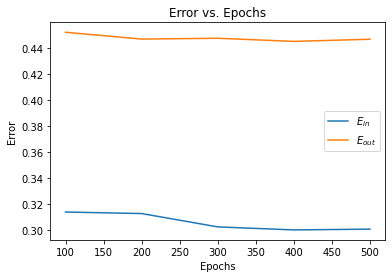

In [ ]:
# rates = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
reg=1e-1
eta = 0.03
E_in, E_out = [], []
epochs = [100, 200, 300, 400, 500]
for epoch in epochs:
    print(epoch)
    U, V, err = train_model(M, N, K, eta, reg, Y_train, max_epochs=epoch)
    E_in.append(err)
    E_out.append(get_err(U, V, Y_test))

plt.plot(epochs, E_in, label='$E_{in}$')
plt.plot(epochs, E_out, label='$E_{out}$')
plt.title('Error vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

### The Model

In [ ]:
U, V, err = train_model(M, N, 20, 0.03, .1, Y_train)

In [ ]:
print('$E_{out}$ = ', get_err(U, V, Y_test))

$E_{out}$ =  0.44809537593018883


## Visualizing Latent Factors

In [ ]:
A, S, B = np.linalg.svd(np.transpose(V))

In [ ]:
proj = np.transpose(A[:, :2])

In [ ]:
np.shape(proj), np.shape(V), np.shape(U)

((2, 20), (1682, 20), (943, 20))

In [ ]:
V_proj = np.dot(proj, np.transpose(V))
# U_proj = np.dot(proj, U)

In [ ]:
# scale dimensions
V_proj /= V_proj.std(axis=1).reshape(2,1)

In [ ]:
full_data = load_data('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv')

In [ ]:
# get hyperparams: average rating & popularity (number of ratings)
full_data = full_data.astype('int32')
movie_count = max(full_data[:, 1]).astype('int32')
rating_count = np.zeros(movie_count)
sum_ratings = np.zeros(movie_count)

for (i, j, rating) in full_data:
    rating_count[j-1] += 1
    sum_ratings[j-1] += rating
average_rating = sum_ratings/rating_count

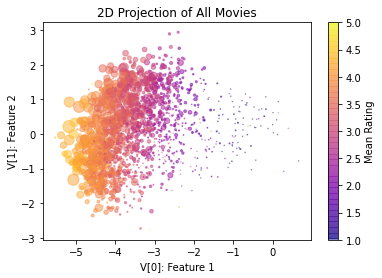

In [ ]:
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of All Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")
plt.show()

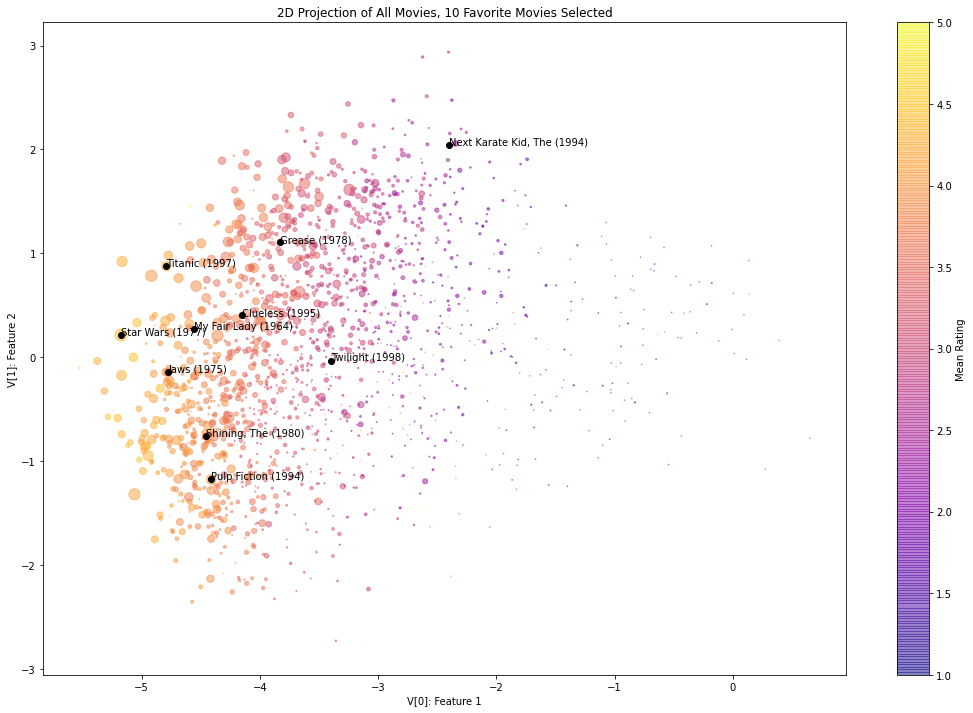

In [ ]:
plt.figure(figsize=(18, 12))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of All Movies, 10 Favorite Movies Selected")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")

chosen_movie_list = ['My Fair Lady (1964)',  'Twilight (1998)', 'Clueless (1995)', 'Titanic (1997)', 'Star Wars (1977)', 'Grease (1978)', 'Jaws (1975)', 'Pulp Fiction (1994)', 'Shining, The (1980)', 'Next Karate Kid, The (1994)']

chosen_movie_idx = []
for movie in chosen_movie_list:
    idx = movies.index[movies['Movie Title'] == movie]
    chosen_movie_idx.append(idx)

for i in range(len(chosen_movie_idx)):
  index = chosen_movie_idx[i]
  x = V_proj[0][index]
  y = V_proj[1][index]
  plt.plot(x, y, 'ko')
  plt.annotate(chosen_movie_list[i], (x, y))
plt.show()

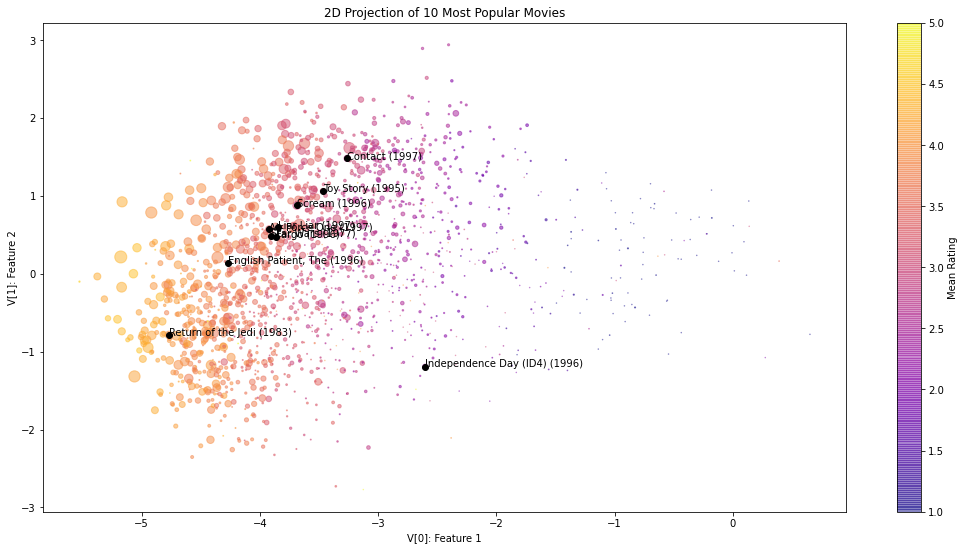

In [ ]:
import collections

movie_ids = data2['Movie ID']
counter = collections.Counter(movie_ids)
popular10 = counter.most_common()[:10]

movie_list = movies["Movie Title"].tolist()

plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Most Popular Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")

for index, _ in popular10:
  x = V_proj[0][index]
  y = V_proj[1][index]
  plt.plot(x, y, 'ko')
  plt.annotate(movie_list[int(index) - 1], (x, y))
plt.show()

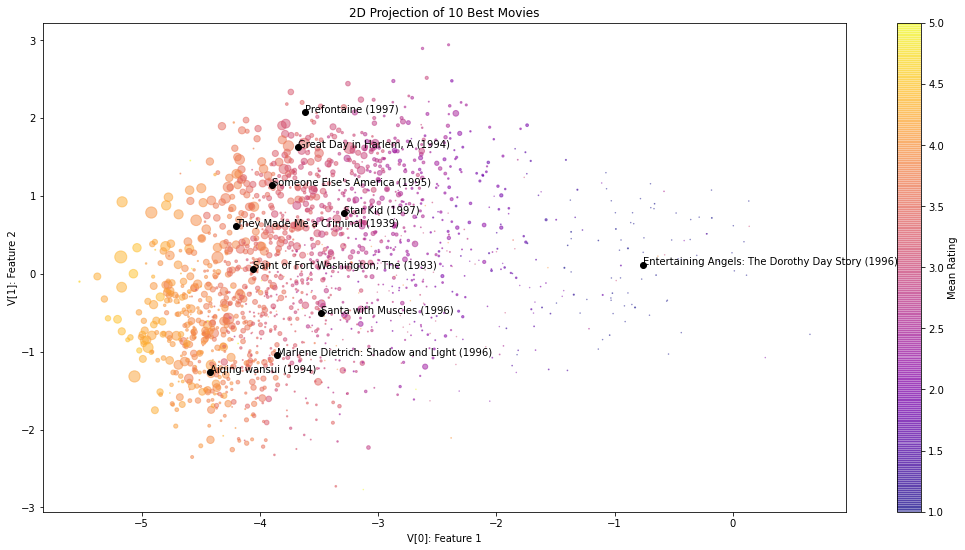

In [ ]:
movie_to_ratings = {}
for movie_id in movie_ids:
  movie_to_ratings[movie_id] = []
for i in range(len(data2)): 
  movie_to_ratings[data2.iloc[i]["Movie ID"]].append(data2.iloc[i]["Rating"])
for movie in movie_to_ratings:
  movie_to_ratings[movie] = np.mean(movie_to_ratings[movie])
movie_to_ratings_sorted = sorted(movie_to_ratings.items(), key=lambda x: x[1], reverse=True)
best10 = movie_to_ratings_sorted[:10]


plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Best Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")

for index, _ in best10:
  x = V_proj[0][index]
  y = V_proj[1][index]
  plt.plot(x, y, 'ko')
  plt.annotate(movie_list[int(index) - 1], (x, y))
plt.show()

In [ ]:
import collections

counter = collections.Counter(movie_ids)
popular10 = counter.most_common()[:10]

movie_list = movies["Movie Title"].tolist()

movie_to_ratings = {}
for movie_id in movie_ids:
  movie_to_ratings[movie_id] = []
for i in range(len(data2)): 
  movie_to_ratings[data2.iloc[i]["Movie ID"]].append(data2.iloc[i]["Rating"])
for movie in movie_to_ratings:
  movie_to_ratings[movie] = np.mean(movie_to_ratings[movie])
movie_to_ratings_sorted = sorted(movie_to_ratings.items(), key=lambda x: x[1], reverse=True)
best10 = movie_to_ratings_sorted[:10]

movies2 = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv')
rating_col = [x[1] for x in sorted(movie_to_ratings.items(), key=lambda x: x[0])]
movies2['Rating'] = rating_col
frequency_col = [x[1] for x in sorted(counter.most_common(), key=lambda x:x)]
movies2['Frequency'] = frequency_col
movies2.drop("Movie Title", axis=1, inplace=True)

noir = movies2[movies2["Film-Noir"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)
horror = movies2[movies2["Horror"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)
children = movies2[movies2["Childrens"] == 1].sort_values(by=['Frequency', 'Rating'], ascending=False)

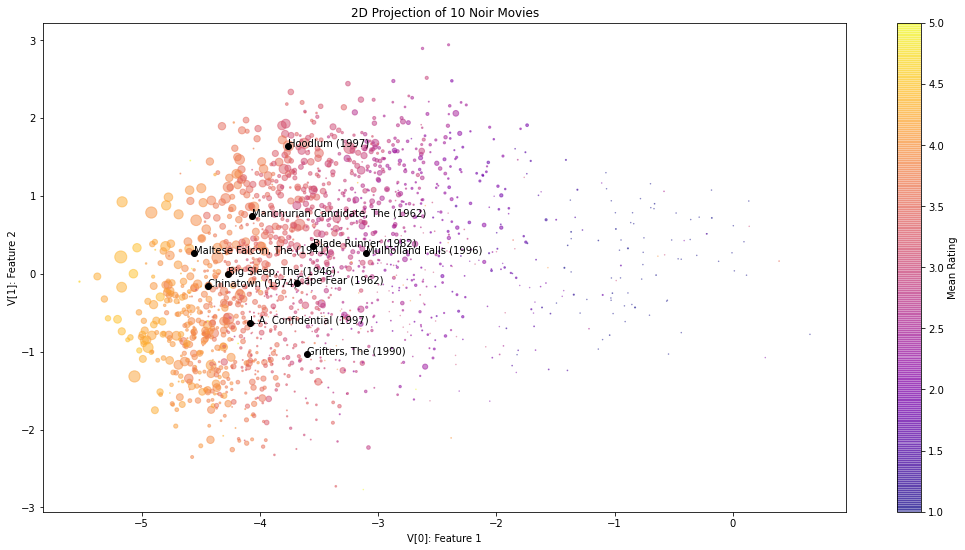

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Noir Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(noir.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x, y, 'ko')
    plt.annotate(title, (x,y))

plt.show()

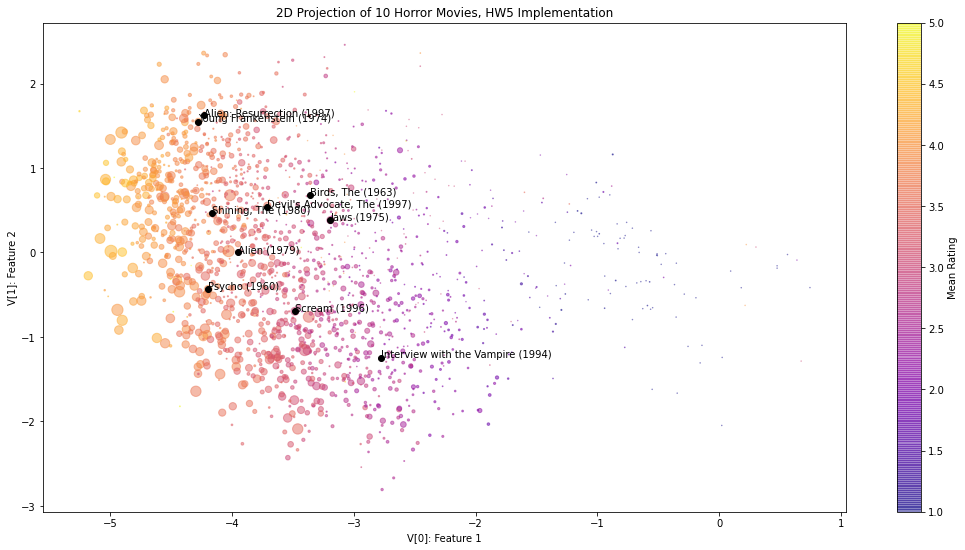

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Horror Movies, HW5 Implementation")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(horror.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x, y, 'ko')
    plt.annotate(title, (x,y))

plt.show()

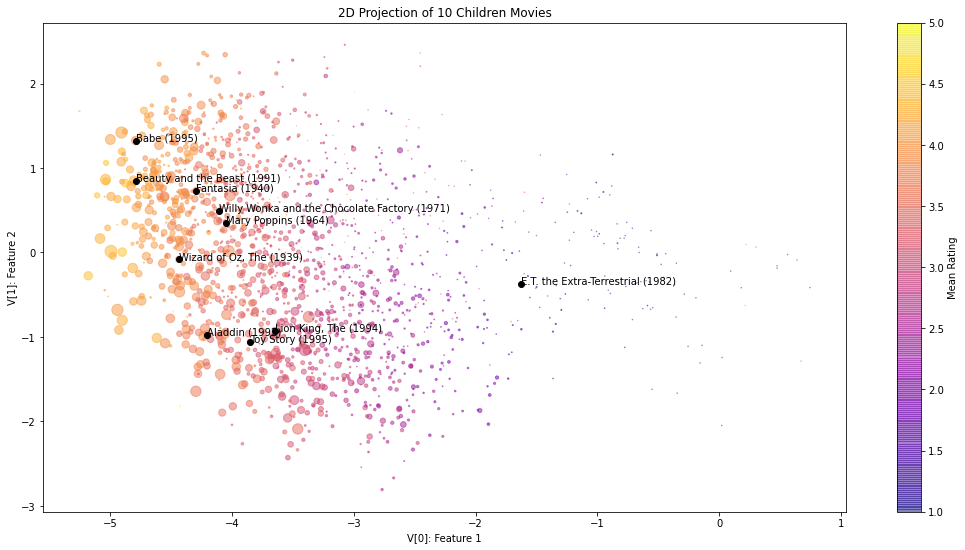

In [ ]:
plt.figure(figsize=(18, 9))
plt.scatter(V_proj[0], V_proj[1], s=rating_count/4, c=average_rating, cmap='plasma', alpha=0.5)
plt.title("2D Projection of 10 Children Movies")
plt.colorbar().set_label("Mean Rating")
plt.xlabel("V[0]: Feature 1")
plt.ylabel("V[1]: Feature 2")


for i in range(10):
    idx = int(children.iloc[i]["Movie ID"])
    title = movie_list[int(idx)-1] 
    x = V_proj[0][idx]
    y = V_proj[1][idx]
    plt.plot(x, y, 'ko')
    plt.annotate(title, (x,y))

plt.show()